![alt text](http://drive.google.com/uc?export=view&id=14ntykAbqwk9malyPFqbvpbnm-VXaOCez)

# Time Series Forecasting Using LSTM in Keras-TensorFlow


## Overview

Time series forecasting is a crucial task in many fields, such as finance, economics, weather prediction, and more. It involves predicting future values based on previously observed values. Traditional forecasting methods, such as ARIMA, have been widely used, but with the advent of deep learning, more advanced techniques like Long Short-Term Memory (LSTM) networks have gained popularity. LSTM is a type of recurrent neural network (RNN) that is well-suited for sequence prediction problems. Unlike traditional RNNs, LSTMs are capable of learning long-term dependencies, making them effective for time series forecasting.

In this tutorial, we will explore how to use LSTM networks for time series forecasting using Keras, and TensorFlow. Keras is a high-level neural networks API that runs on top of TensorFlow, making it easier to build and train deep learning models.



## Load Packages

In [ ]:
!pip install keras-tuner --upgrade

In [ ]:
import os
import numpy as np
from numpy import concatenate

import math, time
from math import sqrt
import random
import numpy as np
from numpy import concatenate

import pandas as pd
from pandas import read_csv
from pandas import DataFrame
from pandas import concat

from datetime import datetime, timedelta
from matplotlib import pyplot
import matplotlib.pylab as plt
from matplotlib.ticker import MultipleLocator, FormatStrFormatter

import seaborn as sns

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error

from tensorflow import keras
import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from keras import layers
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense, Dropout
from keras.models import save_model
from keras.models import model_from_json
from keras.callbacks import EarlyStopping

import keras_tuner as kt
from keras_tuner.tuners import BayesianOptimization

## **Data**

In this exercise, we will utilize monthly time series data on commodity prices sourced from Index Mundi, alongside the Volatility Index (VIX Index). The VIX Index serves as the benchmark for measuring the market's expectations of future volatility and is based on options for the S&P 500 Index, which is regarded as a leading indicator of the overall U.S. stock market. Our objective is to forecast wheat prices six months into the future using Long Short-Term Memory (LSTM) networks, implemented with Keras and TensorFlow.

### Load Dataset

In [ ]:
# Load the dataset
url = 'https://github.com/ahhmed207/r-colab/blob/main/Data/Machine_Learning/monthly_price.csv?raw=true'
df = pd.read_csv(url)
# Reorder column
column_names = ['MONTH','Wheat_Price', 'Crude_Oil_Price', 'Urea_Price', 'TSP_Price', 'MP_Price', 'VIX_Index']
df = df.reindex(columns=column_names)
df.head()

,MONTH,Wheat_Price,Crude_Oil_Price,Urea_Price,TSP_Price,MP_Price,VIX_Index
0,Mar-92,179.04,17.45,120.0,120.0,110.0,17.52
1,Apr-92,168.96,18.63,120.0,120.2,110.0,16.56
2,May-92,164.20,19.50,120.0,120.5,110.0,15.08
3,Jun-92,164.60,20.83,120.0,120.5,110.0,15.20
4,Jul-92,155.25,20.17,120.0,120.5,110.0,13.60


#### Plot Data

In [ ]:
import plotly.graph_objects as go
import plotly.io as pio
pio.renderers.default='colab'
from plotly.subplots import make_subplots

fig = make_subplots(rows=6, cols=1, shared_xaxes=True,
                    vertical_spacing=0.04,
                    subplot_titles=("Wheat","Crude Oil", "Urea", "TSP", "MP", "VIX-Index"),
                    y_title='Price (US $/MT)')

fig.append_trace(go.Scatter(
    x=df['MONTH'],
    y=df['Wheat_Price'],
    name='Wheat Price'
), row=1, col=1)

fig.append_trace(go.Scatter(
    x=df['MONTH'],
    y=df['Crude_Oil_Price'],
    name='Crude Oil Price'
), row=2, col=1)

fig.append_trace(go.Scatter(
    x= df['MONTH'],
    y=df['Urea_Price'],
    name='Urea Price'
), row=3, col=1)

fig.append_trace(go.Scatter(
    x=df['MONTH'],
    y=df['TSP_Price'],
    name='TSP Price'
), row=4, col=1)

fig.append_trace(go.Scatter(
    x=df['MONTH'],
    y=df['MP_Price'],
    name='MP Price'
), row=5, col=1)

fig.append_trace(go.Scatter(
    x=df['MONTH'],
    y=df['VIX_Index'],
    name='VIX Index'
), row=6, col=1)

fig.update_layout(width=600, height=1000, showlegend=False,
                title = {"text": "Monthly Price", "x":0.5, "pad": {'b':0, 'l':0, 't':0, 'r':0}}
                      )
fig.show()

### Data Processing

In [ ]:
#Variables for training
cols = list(df)[1:7]
cols

['Wheat_Price',
 'Crude_Oil_Price',
 'Urea_Price',
 'TSP_Price',
 'MP_Price',
 'VIX_Index']

In [ ]:
# New dataframe with only training data - 5 columns
price_df = df[cols].astype(float)
price_df.head()

,Wheat_Price,Crude_Oil_Price,Urea_Price,TSP_Price,MP_Price,VIX_Index
0,179.04,17.45,120.0,120.0,110.0,17.52
1,168.96,18.63,120.0,120.2,110.0,16.56
2,164.20,19.50,120.0,120.5,110.0,15.08
3,164.60,20.83,120.0,120.5,110.0,15.20
4,155.25,20.17,120.0,120.5,110.0,13.60


#### Heat Map  for Correlation

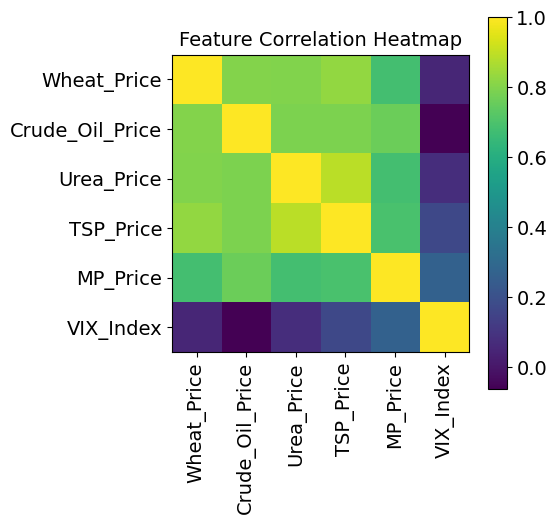

In [ ]:
def show_heatmap(data):
    plt.matshow(data.corr())
    plt.xticks(range(data.shape[1]), data.columns, fontsize=14, rotation=90)
    plt.gca().xaxis.tick_bottom()
    plt.yticks(range(data.shape[1]), data.columns, fontsize=14)

    cb = plt.colorbar()
    cb.ax.tick_params(labelsize=14)
    plt.title("Feature Correlation Heatmap", fontsize=14)
    plt.show()


show_heatmap(price_df)

#### **Scale Data**

In [ ]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler = scaler.fit(price_df)
df_scaled = scaler.transform(price_df)
df_scaled.shape

(362, 6)

### **Convert Series to Supervised Learning**

As required for LSTM networks, we require to reshape an input data into n_samples x timesteps x n_features. In this example, the n_features is 5. We will make timesteps = 6 (past six month  used for training).

In [ ]:
#As required for LSTM networks, we require to reshape an input data into n_samples x timesteps x n_features.
#In this example, the n_features is 5. We will make timesteps = 6(past months data used for training).

#Empty lists to be populated using formatted training data
X_data = []
y_data = []
month=[]
month_df=df['MONTH']

n_future = 1   # Number of days we want to look into the future based on the past days.
n_past = 6  # Number of past days we want to use to predict the future.

#Reformat input data into a shape: (n_samples x timesteps x n_features)
#In my example, my df_for_training_scaled has a shape (12823, 5)
#12823 refers to the number of data points and 5 refers to the columns (multi-variables).
for i in range(n_past, len(df_scaled) - n_future +1):
    X_data.append(df_scaled[i - n_past:i, 0:df_scaled.shape[1]])
    y_data.append(df_scaled[i + n_future - 1:i + n_future, 0])
    month.append(month_df[i + n_future-1:i + n_future])

X_data, y_data, month = np.array(X_data), np.array(y_data), np.array(month)

In [ ]:
month.shape, X_data.shape, y_data.shape

((356, 1), (356, 6, 6), (356, 1))

### **Split Data to Training/Validation/Test**

In [ ]:
np.random.seed(7)

q_80 = int(len(df['MONTH']) * .8)
q_90 = int(len(df['MONTH']) * .9)

month_train, X_train, y_train = month[:q_80], X_data[:q_80], y_data[:q_80]
month_val, X_val, y_val = month[q_80:q_90], X_data[q_80:q_90], y_data[q_80:q_90]
month_test, X_test, y_test = month[q_90:], X_data[q_90:], y_data[q_90:]
month_train.shape, X_train.shape, y_train.shape, month_val.shape, X_val.shape, y_val.shape, month_test.shape, X_test.shape, y_test.shape

((289, 1),
 (289, 6, 6),
 (289, 1),
 (36, 1),
 (36, 6, 6),
 (36, 1),
 (31, 1),
 (31, 6, 6),
 (31, 1))

#### **Plot Training/Validation and Test data**

In [ ]:
import plotly.graph_objects as go
import plotly.io as pio
pio.renderers.default='colab'

fig = go.Figure()
fig.add_traces(go.Scatter(x = month_train.flatten(), y= y_train.flatten(), mode='markers', name='Training Data'))
fig.add_traces(go.Scatter(x = month_val.flatten(), y=y_val.flatten(), mode='markers', name='Validation Data'))
fig.add_traces(go.Scatter(x = month_test.flatten(), y=y_test.flatten(), mode='markers', name='Test Data'))
fig.update_layout(width=800, height=600,
                      xaxis_title = "Months", yaxis_title = "Std. Price",
                      title = {"text": "Training, Validation & Test Data", "x":0.5, "pad": {'b':0, 'l':0, 't':0, 'r':0}},
                      legend = {'yanchor':'top', 'y':0.99, 'xanchor':'left', 'x':0.10})

## **Fit a LSTM Model**

Here is a brief note outlining the steps involved in fitting an LSTM model using Keras and TensorFlow:

1. **Build the LSTM Model:**
   - Initialize a Sequential model.
   - Add LSTM layers with specified units and input shape.
   - Optionally, add Dropout layers to prevent overfitting.
   - Add a Dense layer with the appropriate number of output units.

4. **Compile the Model:**
   - Compile the model with an optimizer (e.g., Adam) and a loss function (e.g., Mean Squared Error).

5. **Define Callbacks:**
   - Set up callbacks such as EarlyStopping to monitor validation loss and stop training when it stops improving.
   - Set up ModelCheckpoint to save the best model during training.

6. **Train the Model:**
   - Use the `fit` method to train the model on the training data.
   - Pass the validation data and callbacks to the `fit` method.
   - Specify the number of epochs and batch size.

7. **Evaluate the Model:**
   - After training, evaluate the model's performance on the validation set.
   - Plot training and validation loss to inspect the model's behavior.



### **Build  a LSTM Model**

The below code sets up a `Sequential model` with two `LSTM layers` and a `Dropout layer` for regularization. The model is designed to handle time series data and is compiled with the `Adam optimizer` and mean `squared error los`s function

1. `np.random.seed(7)`
   - This line sets the seed for NumPy's random number generator to ensure reproducibility. Setting a seed makes sure that the same random numbers are generated every time the code runs, which is useful for debugging and consistent results.

2. `model = Sequential()`
   - This initializes a Sequential model in Keras. A Sequential model is a linear stack of layers, meaning that the layers are added one after the other.

3. `model.add(LSTM(300, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True))`
   - This adds an LSTM (Long Short-Term Memory) layer with 300 units to the model. The `input_shape` parameter specifies the shape of the input data, which is derived from `X_train`. `input_shape=(X_train.shape[1], X_train.shape[2])` means the input data has a shape of (timesteps, features).
   - `return_sequences=True` means that the LSTM layer will return the full sequence of outputs for each input sequence, which is necessary when stacking LSTM layers.

4. `model.add(Dropout(0.2))`
   - This adds a Dropout layer with a rate of 0.2 to the model. Dropout is a regularization technique used to prevent overfitting by randomly setting a fraction (20% in this case) of input units to 0 at each update during training.

5. `model.add(LSTM(150, return_sequences=False))`
   - This adds another LSTM layer with 150 units. `return_sequences=False` means that this LSTM layer will only return the last output in the output sequence, not the full sequence.

6. `model.add(Dense(y_train.shape[1]))`
   - This adds a Dense (fully connected) layer to the model with the number of units equal to the number of features in the target variable `y_train`. This layer will produce the final output of the model.

7. `model.compile(optimizer=keras.optimizers.Adam(learning_rate=1e-3), loss="mse")`
   - This compiles the model, specifying the optimizer and loss function to be used.
   - The Adam optimizer is used with a learning rate of 0.001. Adam is an adaptive learning rate optimization algorithm that's efficient and widely used.
   - The loss function is set to mean squared error (mse), which is commonly used for regression tasks.

8. `model.summary()`
   - This prints a summary of the model, including the layers, output shapes, and the number of parameters in each layer.

In summary, this code sets up a Sequential model with two LSTM layers and a Dropout layer for regularization. The model is designed to handle time series data and is compiled with the Adam optimizer and mean squared error loss function. Finally, the model's architecture is printed out.

#### Code:

In [ ]:
np.random.seed(7)
model = Sequential()
model.add(LSTM(300, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(150, return_sequences=False))
model.add(Dense(y_train.shape[1]))
model.compile(optimizer=keras.optimizers.Adam(learning_rate=1e-3), loss="mse")
model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 6, 300)              │         368,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 6, 300)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 150)                 │         270,600 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │             151 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 639,151 (2.44 MB)

 Trainable params: 639,151 (2.44 MB)

 Non-trainable params: 0 (0.00 B)

### **Compile the Model**

#### **Define Callbacks for Early Stopping**


 Code for Eraly stopping sets up two callbacks for training a Keras model:

1. `path_checkpoint = "model_checkpoint.h5"`
   - This line defines a variable `path_checkpoint` that holds the file path where the model checkpoint will be saved. In this case, the file is named `model_checkpoint.h5`.

2. `es_callback = EarlyStopping(monitor="val_loss", min_delta=0.001, patience=40)`
   - This line creates an EarlyStopping callback. EarlyStopping is used to stop training when a monitored metric has stopped improving.
     - `monitor="val_loss"`: This specifies that the validation loss will be monitored.
     - `min_delta=0.001`: This is the minimum change in the monitored metric to qualify as an improvement. If the change is less than `0.001`, it is considered no improvement.
     - `patience=40`: This is the number of epochs with no improvement after which training will be stopped. In this case, if the validation loss does not improve for 40 consecutive epochs, training will stop.

3. `modelckpt_callback = keras.callbacks.ModelCheckpoint(`
   - This line initializes a ModelCheckpoint callback, which saves the model or its weights at certain intervals during training.
   - The parameters for `ModelCheckpoint` are as follows:
     - `monitor="val_loss"`: The metric to be monitored. In this case, it's the validation loss.
     - `filepath=path_checkpoint`: The path where the model checkpoint will be saved. This uses the `path_checkpoint` variable defined earlier.
     - `verbose=1`: This parameter controls the verbosity of the output. Setting it to `1` means that messages will be printed when the model is saved.
     - `save_weights_only=True`: This specifies that only the model weights will be saved, not the entire model architecture.
     - `save_best_only=True`: This ensures that only the best model (i.e., the model with the lowest validation loss) will be saved.



##### Code:

In [ ]:
path_checkpoint = "model_checkpoint.weights.h5"  # Changed the file extension
es_callback = EarlyStopping(monitor="val_loss", min_delta=0.001, patience=40)

modelckpt_callback = keras.callbacks.ModelCheckpoint(
    monitor="val_loss",
    filepath=path_checkpoint,
    verbose=1,
    save_weights_only=True,
    save_best_only=True,
)

#### **Train the Model**

Below code trains the Keras model on the training data (`X_train`, `y_train`) for 100 epochs with a batch size of 10. It uses validation data (`X_val`, `y_val`) to monitor performance and employs early stopping and model checkpointing callbacks to manage training.

1. `history = model.fit(...)`
   - This line calls the `fit` method of the Keras model to start training the model on the training data. The `fit` method returns a `History` object that contains the training history, which can be used to analyze the model's performance over epochs.

2. `X_train, y_train`
   - These are the training data and labels. `X_train` contains the input features, and `y_train` contains the corresponding target values.

3. `epochs=100`
   - This specifies the number of epochs (iterations over the entire dataset) for which the model will be trained. In this case, the model will be trained for 100 epochs.

4. `batch_size=10`
   - This defines the number of samples per gradient update. The model will update its weights after processing every batch of 10 samples.

5. `validation_data=(X_val, y_val)`
   - This is the validation data and labels. `X_val` contains the input features for validation, and `y_val` contains the corresponding target values. The model will evaluate its performance on this validation data at the end of each epoch to monitor overfitting and track progress.

6. `shuffle=False`
   - This parameter specifies whether to shuffle the training data before each epoch. Setting `shuffle=False` means that the training data will not be shuffled, which can be important for time series data where the order of samples matters.

7. `callbacks=[es_callback, modelckpt_callback]`
   - This specifies the list of callback functions to be applied during training. In this case, two callbacks are used:
     - `es_callback`: The EarlyStopping callback, which stops training if the validation loss does not improve for a specified number of epochs (patience).
     - `modelckpt_callback`: The ModelCheckpoint callback, which saves the model's weights to a file whenever the validation loss improves, ensuring that the best model is saved.

8. `verbose=2`
   - This sets the verbosity mode. Setting `verbose=2` means that the training progress will be printed in a more detailed format, showing one line per epoch.


##### Code:

In [ ]:
history = model.fit(X_train,
                    y_train,
                    epochs=100,
                    batch_size=10,
                    validation_data=(X_val, y_val),
                    shuffle=False,
                    callbacks=[es_callback, modelckpt_callback],
                    verbose=2)


### **Evaluate the Model**

#### Plot Training and Validation History

In [ ]:
# Prediction
y_train_pred= model.predict(X_train)
# Invers-transformation of Predicted Data
train_predicted_copies = np.repeat(y_train_pred, df_scaled.shape[1], axis=-1)
train_predicted = scaler.inverse_transform(train_predicted_copies)[:,0]
# Invers-transformation of Observed Data
train_observed_copies = np.repeat(y_train, df_scaled.shape[1], axis=-1)
train_observed = scaler.inverse_transform(train_observed_copies)[:,0]
train_pred_df = pd.DataFrame({"Predicted":train_predicted, "Observed": train_observed})
train_pred_df["MONTHS"]=month_train.flatten()
y_train_pred.shape, train_pred_df.head()


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


((289, 1),
     Predicted  Observed  MONTHS
 0  125.134514    156.63  Sep-92
 1  131.173218    160.55  Oct-92
 2  136.629745    169.14  Nov-92
 3  143.044556    164.21  Dec-92
 4  139.138458    173.10  Jan-93)

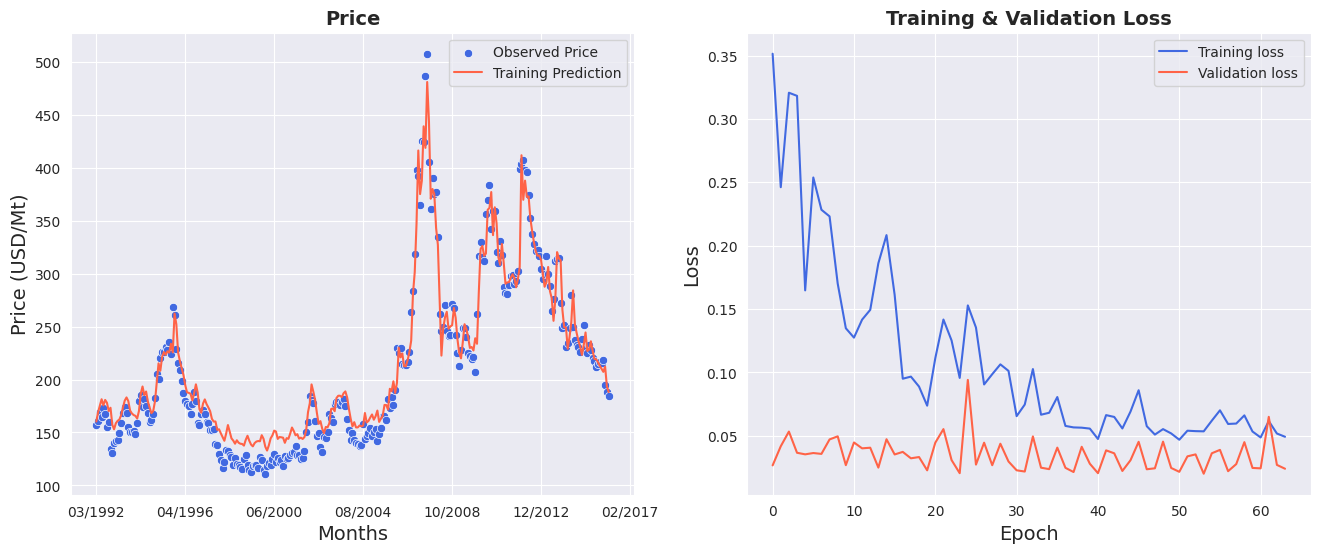

In [ ]:
import seaborn as sns
sns.set_style("darkgrid")

fig = plt.figure()
fig.subplots_adjust(hspace=0.2, wspace=0.2)

plt.subplot(1, 2, 1)
ax = sns.scatterplot(x = train_pred_df["MONTHS"], y = train_pred_df["Observed"], label="Observed Price", color='royalblue')
ax = sns.lineplot(x = train_pred_df["MONTHS"], y = train_pred_df["Predicted"], label="Training Prediction", color='tomato')
ax.set_title('Price', size = 14, fontweight='bold')
ax.set_xlabel("Months", size = 14)
ax.set_ylabel("Price (USD/Mt)", size = 14)
#ax.set_xticklabels('', size=10)
ax.set_xticks([0, 50, 100, 150, 200,250,300])
ax.set_xticklabels(['03/1992', '04/1996', '06/2000', '08/2004', '10/2008','12/2012','02/2017'], size=10)

plt.subplot(1, 2, 2)
ax = sns.lineplot(data=history.history['loss'], label='Training loss', color='royalblue')
ax = sns.lineplot(data=history.history['val_loss'], label='Validation loss', color='tomato')
ax.set_xlabel("Epoch", size = 14)
ax.set_ylabel("Loss", size = 14)
ax.set_title("Training & Validation Loss", size = 14, fontweight='bold')
fig.set_figheight(6)
fig.set_figwidth(16)
plt.show()

#### **Prediction at Validation data**

In [ ]:
# Prediction
y_val_pred= model.predict(X_val)
# Invers-transformation of Predicted Data
val_predicted_copies = np.repeat(y_val_pred, price_df.shape[1], axis=-1)
val_predicted = scaler.inverse_transform(val_predicted_copies)[:,0]
# Invers-transformation of Observed Data
val_observed_copies = np.repeat(y_val, price_df.shape[1], axis=-1)
val_observed = scaler.inverse_transform(val_observed_copies)[:,0]
val_pred_df = pd.DataFrame({"Predicted":val_predicted, "Observed": val_observed})
val_pred_df["MONTHS"]=month_val.flatten()
val_pred_df.head()

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


,Predicted,Observed,MONTHS
0,170.799179,187.75,16-Oct
1,171.829605,186.26,16-Nov
2,170.219772,186.64,16-Dec
3,169.506943,194.80,17-Jan
4,173.358261,201.83,17-Feb


#### **Prediction at Test data**

In [ ]:
# Prediction
y_test_pred= model.predict(X_test)
# Invers-transformation of Predicted Data
test_predicted_copies = np.repeat(y_test_pred, price_df.shape[1], axis=-1)
test_predicted = scaler.inverse_transform(test_predicted_copies)[:,0]
# Invers-transformation of Observed Data
test_observed_copies = np.repeat(y_test, price_df.shape[1], axis=-1)
test_observed = scaler.inverse_transform(test_observed_copies)[:,0]
test_pred_df = pd.DataFrame({"Predicted":test_predicted, "Observed": test_observed})
test_pred_df["MONTHS"]=month_test.flatten()
test_pred_df.head()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


,Predicted,Observed,MONTHS
0,219.086670,233.33,19-Oct
1,229.510941,236.87,19-Nov
2,229.997955,247.30,19-Dec
3,238.122574,259.53,20-Jan
4,251.942535,252.10,20-Feb


#### **Model Performance Matrix**

In [ ]:
def all_metrics(pred_df, method_name):
  import numpy as np
  # Mean Absolute Error (MAE)
  mae = np.mean(np.abs(pred_df['Predicted'].values - pred_df['Observed'].values))
  #print('MAE: %.3f' % mae)

  # Mean Absolute Percentage Error (MAPE)
  mape = np.mean(np.abs(pred_df['Predicted'].values - pred_df['Observed'].values)/pred_df['Observed'].values)
  #print('MAPE: %.3f' % mape)

  # Mean squared error (MSE)
  mse =((pred_df['Predicted'].values - pred_df['Observed'].values) ** 2).mean()
  #print('MSE: %.3f' % mse)

  # Root Mean squared error (RMSE)
  rmse =np.sqrt(((pred_df['Predicted'].values - pred_df['Observed'].values) ** 2).mean())
  #print('RMSE: %.3f' % rmse)

  # Symmetric Mean Absolute Percentage Error (SMAPE)
  smape = ((np.abs(pred_df['Observed'].values - pred_df['Predicted'].values) / (pred_df['Observed'].values + pred_df['Predicted'].values)).sum()) * (
              2.0 / pred_df['Observed'].values.size )
  #print('SMAPE: %.3f' % smape)

  # Create a pd DataFrame
  metrics_df=[{'MAE': mae, 'MAPE':  mape, 'MSE': mse, 'RMSE' : rmse, 'SMAPE': smape}]
  merge_df=pd.DataFrame(metrics_df).round(3)
  merge_df.index = [method_name]

  return merge_df



In [ ]:
train_metrics = all_metrics(train_pred_df, method_name='Training')
val_metrics = all_metrics(val_pred_df, method_name='Validation')
test_metrics = all_metrics(test_pred_df, method_name='Test')

# combining all metrics dataframe
model_metrics = pd.concat([train_metrics, val_metrics, test_metrics])
model_metrics


,MAE,MAPE,MSE,RMSE,SMAPE
Training,22.271,0.122,657.045,25.633,0.131
Validation,16.033,0.076,356.513,18.882,0.078
Test,23.630,0.078,980.120,31.307,0.076


#### **Plot Predicted Price**

In [ ]:
import plotly.graph_objects as go
import plotly.io as pio
pio.renderers.default='colab'

fig = go.Figure()
fig.add_traces(go.Scatter(x = train_pred_df["MONTHS"], y = train_pred_df["Observed"], mode='markers',  name='Training Observed'))
fig.add_traces(go.Scatter(x = train_pred_df["MONTHS"],y = train_pred_df["Predicted"], mode='lines', name='Training Prediction'))
fig.add_traces(go.Scatter(x = val_pred_df["MONTHS"], y = val_pred_df["Observed"], mode='markers',  name='Validation  Observed'))
fig.add_traces(go.Scatter(x = val_pred_df["MONTHS"], y = val_pred_df["Predicted"], mode='lines', name='Validation Prediction'))
fig.add_traces(go.Scatter(x = test_pred_df["MONTHS"], y = test_pred_df["Observed"], mode='markers',  name='Test  Observed'))
fig.add_traces(go.Scatter(x = test_pred_df["MONTHS"], y = test_pred_df["Predicted"], mode='lines', name='Test Prediction'))
#fig.add_traces(go.Scatter(x = month_test.flatten(), y=y_test.flatten(), mode='lines', name='Test Data'))
fig.update_layout(width=900, height=600,
                      xaxis_title = "Months", yaxis_title = "Wheat Price (US$/Mt)",
                      title = {"text": "Global Wheat Price: Keras/TensorFlow-Multivariate LSTM", "x":0.5, "pad": {'b':0, 'l':0, 't':0, 'r':0}},
                      legend = {'yanchor':'top', 'y':0.99, 'xanchor':'left', 'x':0.10})

## **LSTM Model with Hyper-Parameter Tunning**

Hyper-parameter tuning is crucial for optimizing the performance of LSTM models. By carefully selecting and tuning hyper-parameters, you can significantly improve the accuracy and efficiency of your time series forecasting models. Techniques like Grid Search, Random Search, and Bayesian Optimization can help automate and streamline this process.

There are several packages available for hyperparameter tuning Keras LSTM models. Here are some popular ones:

1. **Keras Tuner**:
   - **Description**: An easy-to-use, scalable hyperparameter optimization framework that can be used to tune the hyperparameters of your Keras models.
   - **Installation**: `pip install keras-tuner`
   - **Documentation**: [Keras Tuner Documentation](https://keras.io/keras_tuner/)

2. **Hyperopt**:
   - **Description**: A powerful library for hyperparameter optimization, supporting various search algorithms including random search, grid search, and Bayesian optimization.
   - **Installation**: `pip install hyperopt`
   - **Documentation**: [Hyperopt Documentation](http://hyperopt.github.io/hyperopt/)

3. **Optuna**:
   - **Description**: A hyperparameter optimization framework that is fast and easy to use. It supports both random search and more sophisticated algorithms like TPE (Tree-structured Parzen Estimator).
   - **Installation**: `pip install optuna`
   - **Documentation**: [Optuna Documentation](https://optuna.readthedocs.io/en/stable/)

4. **Scikit-Optimize (skopt)**:
   - **Description**: A simple and efficient library for sequential model-based optimization (SMBO) that works with Scikit-Learn compatible models, including Keras models.
   - **Installation**: `pip install scikit-optimize`
   - **Documentation**: [Scikit-Optimize Documentation](https://scikit-optimize.github.io/)

5. **Bayesian Optimization**:
   - **Description**: A library for Bayesian optimization of black-box functions, which can be used for hyperparameter tuning.
   - **Installation**: `pip install bayesian-optimization`
   - **Documentation**: [Bayesian Optimization Documentation](https://github.com/fmfn/BayesianOptimization)


This example demonstrates how to define a model-building function with hyperparameters and use `Keras Tuner` to find the best hyperparameters for an LSTM model.

### **Hyperparameter Tuning Using Keras Tuner**

KerasTuner is an easy-to-use, scalable hyperparameter optimization framework that solves the pain points of hyperparameter search. Easily configure your search space with a define-by-run syntax, then leverage one of the available search algorithms to find the best hyperparameter values for your models. KerasTuner comes with Bayesian Optimization, Hyperband, and Random Search algorithms built-in, and is also designed to be easy for researchers to extend in order to experiment with new search algorithms. This example demonstrates how to define a model-building function with hyperparameters and use `Keras Tuner` to find the best hyperparameters for an LSTM model.

#### **Defining a Search Space and Building LSTM  Model**

This code defines a function `build_model` that builds a Keras Sequential neural network model with hyperparameter tuning capabilities using `keras-tuner`. Here's a detailed explanation of each part:

1. Model Initialization:
   ```python
   model = tf.keras.Sequential()  # Use tf.keras.Sequential for consistency
   ```
   - Initializes a Sequential model using TensorFlow's Keras API.

2. 1st LSTM Layer:
   ```python
   model.add(LSTM(units=hp.Int('layer_1_neurons', min_value=32, max_value=1024, step=32),
                  activation=hp.Choice('lstm_activation_1', values=['tanh', 'relu']),
                  input_shape=(X_train.shape[1], X_train.shape[2]),
                  return_sequences=True))  
   ```
   - Adds an LSTM (Long Short-Term Memory) layer with:
     - `units`: Number of neurons, chosen dynamically between 32 and 1024 in steps of 32.
     - `activation`: Activation function, chosen dynamically between 'tanh' and 'relu'.
     - `input_shape`: Shape of the input data (only required for the first layer).
     - `return_sequences=True`: Indicates that the layer should return the full sequence of outputs.

3. 1st Dropout Layer:
   ```python
   model.add(layers.Dropout(rate=hp.Float('dropout_1', min_value=0.0, max_value=0.5, default=0.2, step=0.1)))  
   ```
   - Adds a Dropout layer to prevent overfitting with:
     - `rate`: Dropout rate, chosen dynamically between 0.0 and 0.5 in steps of 0.1.

4. 1st Dense Layer:
   ```python
   model.add(Dense(units=hp.Int('units', min_value=32, max_value=1024, step=32),
                   activation=hp.Choice('dense_activation_1', values=['relu', 'tanh', 'sigmoid', 'linear'])))
   ```
   - Adds a Dense (fully connected) layer with:
     - `units`: Number of neurons, chosen dynamically between 32 and 1024 in steps of 32.
     - `activation`: Activation function, chosen dynamically between 'relu', 'tanh', 'sigmoid', and 'linear'.

5. 2nd LSTM Layer:
   ```python
   model.add(LSTM(units=hp.Int('layer_2_neurons', min_value=32, max_value=1024, step=32),
                  activation=hp.Choice('lstm_activation_2', values=['tanh', 'relu']),
                  return_sequences=False))
   ```
   - Adds another LSTM layer similar to the first one but without `input_shape` and `return_sequences` set to `False`.

6. 2nd Dropout Layer:
   ```python
   model.add(layers.Dropout(rate=hp.Float('dropout_2', min_value=0.0, max_value=0.5, default=0.2, step=0.1)))
   ```
   - Adds another Dropout layer similar to the first one.

7. Final Dense Layer:
   ```python
   model.add(Dense(y_train.shape[1], activation='linear'))  
   ```
   - Adds a final Dense layer with:
     - `units`: Number of neurons equal to the number of output features in `y_train`.
     - `activation='linear'`: Linear activation function, which is typical for regression tasks.

8. Model Compilation:
   ```python
   model.compile(loss='mse',
                 metrics=['mse'],
                 optimizer=hp.Choice('optimizer', values=['adam', 'rmsprop', 'sgd']))
   ```
   - Compiles the model with:
     - `loss='mse'`: Mean Squared Error loss function, suitable for regression tasks.
     - `metrics=['mse']`: Tracks Mean Squared Error during training.
     - `optimizer`: Optimizer chosen dynamically between 'adam', 'rmsprop', and 'sgd'.

9. Return Model:
   ```python
   return model
   ```

10. Build Model Call:
    ```python
    build_model(kt.HyperParameters())
    ```
    - Calls the `build_model` function with an instance of `kt.HyperParameters` to initiate hyperparameter tuning.





##### Code:

In [ ]:
import keras_tuner as kt
from keras import layers
import tensorflow as tf

def build_model(hp):
    model = tf.keras.Sequential()  # Use tf.keras.Sequential for consistency

    # 1st LSTM Layer
    # Wider range for neurons and consider using 'tanh' activation
    model.add(LSTM(units=hp.Int('layer_1_neurons', min_value=32, max_value=1024, step=32),
                   activation=hp.Choice('lstm_activation_1', values=['tanh', 'relu']), # Add activation choice
                   input_shape=(X_train.shape[1], X_train.shape[2]),
                   return_sequences=True))

    # 1st Dropout layer
    model.add(layers.Dropout(rate=hp.Float('dropout_1', min_value=0.0, max_value=0.5, default=0.2, step=0.1)))  # Wider dropout range

    # 1st Dense Layer
    # Wider range for units and consider more activation functions
    model.add(Dense(units=hp.Int('units', min_value=32, max_value=1024, step=32),
                    activation=hp.Choice('dense_activation_1', values=['relu', 'tanh', 'sigmoid', 'linear'])))

    # 2nd LSTM Layer
    # Wider range for neurons and consider using 'tanh' activation
    model.add(LSTM(units=hp.Int('layer_2_neurons', min_value=32, max_value=1024, step=32),
                   activation=hp.Choice('lstm_activation_2', values=['tanh', 'relu']), # Add activation choice
                   return_sequences=False))

    # 2nd Dropout layer
    model.add(layers.Dropout(rate=hp.Float('dropout_2', min_value=0.0, max_value=0.5, default=0.2, step=0.1))) # Wider dropout range

    # Final Dense Layer and output layer
    # Consider a linear activation for regression
    model.add(Dense(y_train.shape[1], activation='linear'))

    # Model Compile
    # Wider learning rate range and different optimizers
    model.compile(loss='mse',
                  metrics=['mse'],
                  optimizer=hp.Choice('optimizer', values=['adam', 'rmsprop', 'sgd']))

    return model

build_model(kt.HyperParameters())


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



<Sequential name=sequential_2, built=True>

#### **Hyperparameter Tuning Using Grid Serach**

After defining the search space, we need to select a tuner class to run the search. You may choose from **RandomSearch**, **BayesianOptimization** and **Hyperband**, which correspond to different tuning algorithms.  Here we use **BayesianOptimization** as an example.

1. `keras.backend.clear_session()`

- **Purpose**: This function is used to clear the current Keras session. It helps to free up resources and reset the state of the Keras backend. This is particularly useful when you are creating multiple models in a loop or when you want to clear the previous models and layers from memory to avoid clutter and potential conflicts.
- **Usage**: Typically used at the start of a model-building script to ensure a clean slate.


2. `tuner = BayesianOptimization(...)`

**Bayesian Optimization for Hyperparameter Tuning**

- **Purpose**: This line initializes a Bayesian Optimization tuner using Keras Tuner. Bayesian Optimization is a probabilistic model-based approach for finding the minimum or maximum of a function. It is particularly effective for hyperparameter tuning because it balances exploration (trying new hyperparameters) and exploitation (refining known good hyperparameters).
- **Parameters**:
  - `build_model`: The function that builds the Keras model. It takes an instance of `HyperParameters` and returns a compiled Keras model.
  - `objective='val_loss'`: The metric to be optimized. In this case, it is Mean Squared Error (MSE), which is commonly used for regression tasks.
  - `max_trials=10`: The maximum number of different hyperparameter combinations to try.
 -  `project_name="'D:\my_dir' "`: The directory where the results of the hyperparameter tuning will be saved.
  - `overwrite=True`: If `True`, any existing project with the same name will be overwritten. If `False`, the tuner will resume the previous search.


##### Code:

In [ ]:
# BayesianOptimization

keras.backend.clear_session()

# Define a directory for tuning results (inside the current working directory)
tuning_directory = os.path.join(os.getcwd(), "wheat_price_tuning")

# Initialize the tuner - BayesianOptimization is a good choice
tuner = kt.BayesianOptimization(
    build_model,
    objective='val_loss',  # Optimize for validation loss
    max_trials=5,         # the number of trials
    directory=tuning_directory,  # Use the new directory
    project_name='wheat_price_forecast',
    overwrite=True)  # Add overwrite=True to start fresh)


In [ ]:
# You can print a summary of the search space
tuner.search_space_summary()

Search space summary
Default search space size: 9
layer_1_neurons (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 1024, 'step': 32, 'sampling': 'linear'}
lstm_activation_1 (Choice)
{'default': 'tanh', 'conditions': [], 'values': ['tanh', 'relu'], 'ordered': False}
dropout_1 (Float)
{'default': 0.2, 'conditions': [], 'min_value': 0.0, 'max_value': 0.5, 'step': 0.1, 'sampling': 'linear'}
units (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 1024, 'step': 32, 'sampling': 'linear'}
dense_activation_1 (Choice)
{'default': 'relu', 'conditions': [], 'values': ['relu', 'tanh', 'sigmoid', 'linear'], 'ordered': False}
layer_2_neurons (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 1024, 'step': 32, 'sampling': 'linear'}
lstm_activation_2 (Choice)
{'default': 'tanh', 'conditions': [], 'values': ['tanh', 'relu'], 'ordered': False}
dropout_2 (Float)
{'default': 0.2, 'conditions': [], 'min_value': 0.0, 'max_value': 0.5, 'step': 

#### **Query the Results and Get the Best Model**

Then, start the search for the best hyperparameter configuration. All the arguments passed to search is passed to model.fit() in each execution. Remember to pass validation_data to evaluate the model.


In [ ]:
keras.backend.clear_session()

# Perform the search
tuner.search(X_train,
             y_train,
             epochs=50,
             batch_size=10,
             validation_data=(X_val, y_val),
             callbacks=[es_callback, modelckpt_callback])  # Increase epochs



Trial 10 Complete [00h 13m 16s]
val_loss: 0.0764719545841217

Best val_loss So Far: 0.01691628247499466
Total elapsed time: 01h 15m 57s


In [ ]:
tuner.results_summary()

Results summary
Results in /content/wheat_price_tuning/wheat_price_forecast
Showing 10 best trials
Objective(name="val_loss", direction="min")

Trial 08 summary
Hyperparameters:
layer_1_neurons: 160
lstm_activation_1: tanh
dropout_1: 0.4
units: 576
dense_activation_1: relu
layer_2_neurons: 672
lstm_activation_2: relu
dropout_2: 0.2
optimizer: adam
Score: 0.01691628247499466

Trial 00 summary
Hyperparameters:
layer_1_neurons: 672
lstm_activation_1: relu
dropout_1: 0.1
units: 1024
dense_activation_1: tanh
layer_2_neurons: 672
lstm_activation_2: relu
dropout_2: 0.0
optimizer: adam
Score: 0.01811574399471283

Trial 01 summary
Hyperparameters:
layer_1_neurons: 128
lstm_activation_1: tanh
dropout_1: 0.1
units: 992
dense_activation_1: relu
layer_2_neurons: 768
lstm_activation_2: tanh
dropout_2: 0.4
optimizer: adam
Score: 0.019984062761068344

Trial 06 summary
Hyperparameters:
layer_1_neurons: 384
lstm_activation_1: tanh
dropout_1: 0.4
units: 96
dense_activation_1: linear
layer_2_neurons: 704


#### **Find the Best Model**

In [ ]:
best_hps = tuner.get_best_hyperparameters()
print("Best Hyperparameters:", best_hps)

In [ ]:
# Get the best model
best_model_kt = tuner.get_best_models(num_models=1)[0]
best_model_kt.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.

/usr/local/lib/python3.10/dist-packages/keras/src/saving/saving_lib.py:713: UserWarning:

Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 22 variables. 



Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 6, 160)              │         106,880 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 6, 160)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 6, 576)              │          92,736 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 672)                 │       3,357,312 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 672)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │             673 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,557,601 (13.57 MB)

 Trainable params: 3,557,601 (13.57 MB)

 Non-trainable params: 0 (0.00 B)

#### **Train the Best Model**

In [ ]:
keras.backend.clear_session()

history = best_model_kt.fit(X_train,
                    y_train,
                    epochs=50,
                    batch_size=10,
                    validation_data=(X_val, y_val),
                    shuffle=False,
                    #callbacks=[es_callback, modelckpt_callback],
                    verbose=0)

#### **Model Performance**

In [ ]:
# Training
y_train_pred= best_model_kt.predict(X_train)
# Invers-transformation of Predicted Data
train_predicted_copies = np.repeat(y_train_pred, price_df.shape[1], axis=-1)
train_predicted = scaler.inverse_transform(train_predicted_copies)[:,0]
# Invers-transformation of Observed Data
train_observed_copies = np.repeat(y_train, price_df.shape[1], axis=-1)
train_observed = scaler.inverse_transform(train_observed_copies)[:,0]
train_pred_df = pd.DataFrame({"Predicted":train_predicted, "Observed": train_observed})
train_pred_df["MONTHS"]=month_train.flatten()
y_train_pred.shape, train_pred_df.head()

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step


((289, 1),
     Predicted  Observed  MONTHS
 0  152.376801    156.63  Sep-92
 1  157.656219    160.55  Oct-92
 2  159.063751    169.14  Nov-92
 3  164.284622    164.21  Dec-92
 4  160.392838    173.10  Jan-93)

In [ ]:
# Validation
y_val_pred=best_model_kt.predict(X_val)
# Invers-transformation of Predicted Data
val_predicted_copies = np.repeat(y_val_pred, price_df.shape[1], axis=-1)
val_predicted = scaler.inverse_transform(val_predicted_copies)[:,0]
# Invers-transformation of Observed Data
val_observed_copies = np.repeat(y_val, price_df.shape[1], axis=-1)
val_observed = scaler.inverse_transform(val_observed_copies)[:,0]
val_pred_df = pd.DataFrame({"Predicted":val_predicted, "Observed": val_observed})
val_pred_df["MONTHS"]=month_val.flatten()
val_pred_df.head()

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


,Predicted,Observed,MONTHS
0,177.784256,187.75,16-Oct
1,172.976578,186.26,16-Nov
2,167.955856,186.64,16-Dec
3,168.975281,194.80,17-Jan
4,172.379257,201.83,17-Feb


In [ ]:
# Test
y_test_pred= best_model_kt.predict(X_test)
# Invers-transformation of Predicted Data
test_predicted_copies = np.repeat(y_test_pred, price_df.shape[1], axis=-1)
test_predicted = scaler.inverse_transform(test_predicted_copies)[:,0]
# Invers-transformation of Observed Data
test_observed_copies = np.repeat(y_test, price_df.shape[1], axis=-1)
test_observed = scaler.inverse_transform(test_observed_copies)[:,0]
test_pred_df = pd.DataFrame({"Predicted":test_predicted, "Observed": test_observed})
test_pred_df["MONTHS"]=month_test.flatten()
test_pred_df.head()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step


,Predicted,Observed,MONTHS
0,217.292999,233.33,19-Oct
1,217.893845,236.87,19-Nov
2,219.191879,247.30,19-Dec
3,223.726776,259.53,20-Jan
4,231.627625,252.10,20-Feb


In [ ]:
train_metrics = all_metrics(train_pred_df, method_name='Training')
val_metrics = all_metrics(val_pred_df, method_name='Validation')
test_metrics = all_metrics(test_pred_df, method_name='Test')

# combining all metrics dataframe
model_metrics = pd.concat([train_metrics, val_metrics, test_metrics])
model_metrics

,MAE,MAPE,MSE,RMSE,SMAPE
Training,11.984,0.054,379.708,19.486,0.055
Validation,17.019,0.080,426.269,20.646,0.081
Test,39.341,0.110,4569.499,67.598,0.123


#### **Plot Predicted Price**

In [ ]:
import plotly.graph_objects as go
import plotly.io as pio
pio.renderers.default='colab'

fig = go.Figure()
fig.add_traces(go.Scatter(x = train_pred_df["MONTHS"], y = train_pred_df["Observed"], mode='markers',  name='Training Observed'))
fig.add_traces(go.Scatter(x = train_pred_df["MONTHS"],y = train_pred_df["Predicted"], mode='lines', name='Training Prediction'))
fig.add_traces(go.Scatter(x = val_pred_df["MONTHS"], y = val_pred_df["Observed"], mode='markers',  name='Validation  Observed'))
fig.add_traces(go.Scatter(x = val_pred_df["MONTHS"], y = val_pred_df["Predicted"], mode='lines', name='Validation Prediction'))
fig.add_traces(go.Scatter(x = test_pred_df["MONTHS"], y = test_pred_df["Observed"], mode='markers',  name='Test  Observed'))
fig.add_traces(go.Scatter(x = test_pred_df["MONTHS"], y = test_pred_df["Predicted"], mode='lines', name='Test Prediction'))
#fig.add_traces(go.Scatter(x = month_test.flatten(), y=y_test.flatten(), mode='lines', name='Test Data'))
fig.update_layout(width=900, height=600,
                      xaxis_title = "Months", yaxis_title = "Wheat Price (US$/Mt)",
                      title = {"text": "Global Wheat Price: Keras/TensorFlow-Multivariate LSTM", "x":0.5, "pad": {'b':0, 'l':0, 't':0, 'r':0}},
                      legend = {'yanchor':'top', 'y':0.99, 'xanchor':'left', 'x':0.10})

### **Hyperparameter Tuning Using Optuna**

[Optuna](https://optuna.org/) is an open-source hyperparameter optimization framework designed for machine learning and deep learning models. It automates the search for the best hyperparameters by using various optimization techniques. Here's a concise summary of how Optuna works and how to use it for hyperparameter tuning:

**Key Features:**

* Automated Optimization: Optuna uses state-of-the-art algorithms to automatically find the best hyperparameters.
* Define-by-Run: A flexible approach that allows users to dynamically construct the search space.
* Efficient Search: Uses techniques like Bayesian optimization to efficiently explore the hyperparameter space.

#### **Defining a Search Space and Building LSTM  Model**


This code defines two functions, `build_model` and `objective`, that are used to create and optimize a machine learning model with the help of the Optuna library. The `build_model` function constructs a TensorFlow Keras model, and the `objective` function trains the model and evaluates its performance.

**`build_model(trial)` Function:**

This function builds a Keras Sequential model with hyperparameters suggested by Optuna's `trial` object. Here's a step-by-step explanation:

1. Initialize the Sequential Model:
   ```python
   model = tf.keras.Sequential()
   ```

2. 1st LSTM Layer:
   - Adds an LSTM layer with a number of units (neurons) suggested by Optuna.
   - The activation function is also suggested by Optuna.
   - `input_shape` is set based on the shape of `X_train`.
   - `return_sequences` is set to `True` to return the full sequence.
   ```python
   model.add(LSTM(units=trial.suggest_int('layer_1_neurons', 32, 1024, step=32),
                  activation=trial.suggest_categorical('lstm_activation_1', ['tanh', 'relu']),
                  input_shape=(X_train.shape[1], X_train.shape[2]),
                  return_sequences=True))
   ```

3. 1st Dropout Layer:
   - Adds a Dropout layer to prevent overfitting.
   - The dropout rate is suggested by Optuna.
   ```python
   model.add(layers.Dropout(rate=trial.suggest_float('dropout_1', 0.0, 0.5, step=0.1)))
   ```

4. 1st Dense Layer:
   - Adds a Dense (fully connected) layer with a number of units suggested by Optuna.
   - The activation function is also suggested by Optuna.
   ```python
   model.add(Dense(units=trial.suggest_int('units', 32, 1024, step=32),
                   activation=trial.suggest_categorical('dense_activation_1', ['relu', 'tanh', 'sigmoid', 'linear'])))
   ```

5. 2nd LSTM Layer:
   - Adds another LSTM layer with a number of units suggested by Optuna.
   - The activation function is also suggested by Optuna.
   - `return_sequences` is set to `False` to return only the last output.
   ```python
   model.add(LSTM(units=trial.suggest_int('layer_2_neurons', 32, 1024, step=32),
                  activation=trial.suggest_categorical('lstm_activation_2', ['tanh', 'relu']),
                  return_sequences=False))
   ```

6. 2nd Dropout Layer:
   - Adds another Dropout layer with a rate suggested by Optuna.
   ```python
   model.add(layers.Dropout(rate=trial.suggest_float('dropout_2', 0.0, 0.5, step=0.1)))
   ```

7. Final Dense Layer:
   - Adds a Dense layer as the output layer with a linear activation function.
   - The output size is determined by the shape of `y_train`.
   ```python
   model.add(Dense(y_train.shape[1], activation='linear'))
   ```

8. Compile the Model:
   - Compiles the model with mean squared error (MSE) loss.
   - The optimizer is suggested by Optuna.
   ```python
   model.compile(loss='mse',
                 metrics=['mse'],
                 optimizer=trial.suggest_categorical('optimizer', ['adam', 'rmsprop', 'sgd']))
   ```

**`objective(trial)` Function**:

This function defines the objective for the Optuna optimization process, which involves training the model and evaluating its performance.

1. Build the Model:
   ```python
   model = build_model(trial)
   ```

2. Set Up Early Stopping:
   - Early stopping is used to stop training when the validation loss stops improving.
   - `patience=10` means training will stop if the validation loss doesn't improve for 10 consecutive epochs.
   - `restore_best_weights=True` restores the model weights from the epoch with the best validation loss.
   ```python
   early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
   ```

3. Train the Model:
   - The model is trained with the training data (`X_train`, `y_train`) and validated with the validation data (`X_val`, `y_val`).
   - The number of epochs is set to 50.
   - Early stopping and Optuna's pruning callback are used as callbacks.
   - `verbose=0` silences the training output.
   ```python
   history = model.fit(X_train, y_train,
                       validation_data=(X_val, y_val),
                       epochs=50,
                       callbacks=[early_stopping, TFKerasPruningCallback(trial, 'val_loss')],
                       verbose=0)
   ```

4. *Evaluate the Model:
   - The minimum validation loss from the training history is returned as the objective value.
   ```python
   val_loss = min(history.history['val_loss'])
   return val_loss
   ```

This setup uses Optuna to perform hyperparameter optimization by searching for the best set of hyperparameters that minimize the validation loss. The `objective` function is used by Optuna's optimization routine to evaluate different combinations of hyperparameters.

##### Code:

In [ ]:
!pip install optuna
!pip install optuna-integration[tfkeras]

In [ ]:
import optuna
from optuna.integration import TFKerasPruningCallback
from tensorflow.keras.callbacks import EarlyStopping
from keras import layers
import tensorflow as tf

def build_model(trial):
    model = tf.keras.Sequential()

    # 1st LSTM Layer
    model.add(LSTM(units=trial.suggest_int('layer_1_neurons', 32, 1024, step=32),
                   activation=trial.suggest_categorical('lstm_activation_1', ['tanh', 'relu']),
                   input_shape=(X_train.shape[1], X_train.shape[2]),
                   return_sequences=True))

    # 1st Dropout layer
    model.add(layers.Dropout(rate=trial.suggest_float('dropout_1', 0.0, 0.5, step=0.1)))

    # 1st Dense Layer
    model.add(Dense(units=trial.suggest_int('units', 32, 1024, step=32),
                    activation=trial.suggest_categorical('dense_activation_1', ['relu', 'tanh', 'sigmoid', 'linear'])))

    # 2nd LSTM Layer
    model.add(LSTM(units=trial.suggest_int('layer_2_neurons', 32, 1024, step=32),
                   activation=trial.suggest_categorical('lstm_activation_2', ['tanh', 'relu']),
                   return_sequences=False))

    # 2nd Dropout layer
    model.add(layers.Dropout(rate=trial.suggest_float('dropout_2', 0.0, 0.5, step=0.1)))

    # Final Dense Layer and output layer
    model.add(Dense(y_train.shape[1], activation='linear'))

    # Model Compile
    model.compile(loss='mse',
                  metrics=['mse'],
                  optimizer=trial.suggest_categorical('optimizer', ['adam', 'rmsprop', 'sgd']))

    return model




#### **Define the Objective Function**


**`objective(trial)` Function**:

This function defines the objective for the Optuna optimization process, which involves training the model and evaluating its performance.

1. Build the Model:
   ```python
   model = build_model(trial)
   ```

2. Set Up Early Stopping:
   - Early stopping is used to stop training when the validation loss stops improving.
   - `patience=10` means training will stop if the validation loss doesn't improve for 10 consecutive epochs.
   - `restore_best_weights=True` restores the model weights from the epoch with the best validation loss.
   ```python
   early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
   ```

3. Train the Model:
   - The model is trained with the training data (`X_train`, `y_train`) and validated with the validation data (`X_val`, `y_val`).
   - The number of epochs is set to 50.
   - Early stopping and Optuna's pruning callback are used as callbacks.
   - `verbose=0` silences the training output.
   ```python
   history = model.fit(X_train, y_train,
                       validation_data=(X_val, y_val),
                       epochs=50,
                       callbacks=[early_stopping, TFKerasPruningCallback(trial, 'val_loss')],
                       verbose=0)
   ```

4. Evaluate the Model:
   - The minimum validation loss from the training history is returned as the objective value.
   ```python
   val_loss = min(history.history['val_loss'])
   return val_loss

##### Code:

In [ ]:
def objective(trial):
    model = build_model(trial)
    early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
    history = model.fit(X_train, y_train,
                        validation_data=(X_val, y_val),
                        epochs=50,
                        callbacks=[early_stopping, TFKerasPruningCallback(trial, 'val_loss')],
                        verbose=0)
    val_loss = min(history.history['val_loss'])
    return val_loss

#### **Optimize the Objective Function**

In [ ]:
# Create an Optuna Study
study = optuna.create_study(direction='minimize')
#Optimize the Objective Function
study.optimize(objective, n_trials=5)


[I 2025-01-15 03:23:27,854] A new study created in memory with name: no-name-07130ec1-215b-4831-8f9c-dc502c5cfb25
/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.

[I 2025-01-15 03:25:10,239] Trial 0 finished with value: 0.01837601326406002 and parameters: {'layer_1_neurons': 352, 'lstm_activation_1': 'tanh', 'dropout_1': 0.4, 'units': 608, 'dense_activation_1': 'linear', 'layer_2_neurons': 448, 'lstm_activation_2': 'tanh', 'dropout_2': 0.1, 'optimizer': 'adam'}. Best is trial 0 with value: 0.01837601326406002.
[I 2025-01-15 03:26:46,066] Trial 1 finished with value: 0.024684231728315353 and parameters: {'layer_1_neurons': 704, 'lstm_activation_1': 'tanh', 'dropout_1': 0.0, 'units': 288, 'dense_activation_1': 'linear', 'layer_2_neurons': 320, 'lstm_activation_2': 'relu', 'dropout_

#### **Get the Best Model**

In [ ]:
print("Best hyperparameters: ", study.best_params)

Best hyperparameters:  {'layer_1_neurons': 352, 'lstm_activation_1': 'tanh', 'dropout_1': 0.4, 'units': 608, 'dense_activation_1': 'linear', 'layer_2_neurons': 448, 'lstm_activation_2': 'tanh', 'dropout_2': 0.1, 'optimizer': 'adam'}


In [ ]:
# Get the best model
best_params_op = study.best_trial
best_model_op = build_model(best_params_op)
best_model_op.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_10 (LSTM)                       │ (None, 6, 352)              │         505,472 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_10 (Dropout)                 │ (None, 6, 352)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_10 (Dense)                     │ (None, 6, 608)              │         214,624 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_11 (LSTM)                       │ (None, 448)                 │       1,894,144 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_11 (Dropout)                 │ (None, 448)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_11 (Dense)                     │ (None, 1)                   │             449 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,614,689 (9.97 MB)

 Trainable params: 2,614,689 (9.97 MB)

 Non-trainable params: 0 (0.00 B)

#### **Train Model with the Best Hyperparameters**

In [ ]:
best_model_op.fit(X_train,
               y_train,
               epochs=50,
               validation_data=(X_val, y_val),
               verbose =0)

####  **Model Performance**

In [ ]:
# Training
y_train_pred= best_model_op.predict(X_train)
# Invers-transformation of Predicted Data
train_predicted_copies = np.repeat(y_train_pred, price_df.shape[1], axis=-1)
train_predicted = scaler.inverse_transform(train_predicted_copies)[:,0]
# Invers-transformation of Observed Data
train_observed_copies = np.repeat(y_train, price_df.shape[1], axis=-1)
train_observed = scaler.inverse_transform(train_observed_copies)[:,0]
train_pred_df = pd.DataFrame({"Predicted":train_predicted, "Observed": train_observed})
train_pred_df["MONTHS"]=month_train.flatten()
y_train_pred.shape, train_pred_df.head()

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 103ms/step


((289, 1),
     Predicted  Observed  MONTHS
 0  148.913528    156.63  Sep-92
 1  151.505539    160.55  Oct-92
 2  157.834152    169.14  Nov-92
 3  163.770752    164.21  Dec-92
 4  162.908661    173.10  Jan-93)

In [ ]:
# Validation
y_val_pred=best_model_op.predict(X_val)
# Invers-transformation of Predicted Data
val_predicted_copies = np.repeat(y_val_pred, price_df.shape[1], axis=-1)
val_predicted = scaler.inverse_transform(val_predicted_copies)[:,0]
# Invers-transformation of Observed Data
val_observed_copies = np.repeat(y_val, price_df.shape[1], axis=-1)
val_observed = scaler.inverse_transform(val_observed_copies)[:,0]
val_pred_df = pd.DataFrame({"Predicted":val_predicted, "Observed": val_observed})
val_pred_df["MONTHS"]=month_val.flatten()
val_pred_df.head()

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


,Predicted,Observed,MONTHS
0,187.093185,187.75,16-Oct
1,185.909836,186.26,16-Nov
2,185.152893,186.64,16-Dec
3,183.213760,194.80,17-Jan
4,184.668732,201.83,17-Feb


In [ ]:
# Test
y_test_pred= best_model_op.predict(X_test)
# Invers-transformation of Predicted Data
test_predicted_copies = np.repeat(y_test_pred, price_df.shape[1], axis=-1)
test_predicted = scaler.inverse_transform(test_predicted_copies)[:,0]
# Invers-transformation of Observed Data
test_observed_copies = np.repeat(y_test, price_df.shape[1], axis=-1)
test_observed = scaler.inverse_transform(test_observed_copies)[:,0]
test_pred_df = pd.DataFrame({"Predicted":test_predicted, "Observed": test_observed})
test_pred_df["MONTHS"]=month_test.flatten()
test_pred_df.head()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


,Predicted,Observed,MONTHS
0,224.529617,233.33,19-Oct
1,232.901962,236.87,19-Nov
2,235.453476,247.30,19-Dec
3,245.188293,259.53,20-Jan
4,259.706635,252.10,20-Feb


#### **Plot Predicted Price**

In [ ]:
import plotly.graph_objects as go
import plotly.io as pio
pio.renderers.default='colab'

fig = go.Figure()
fig.add_traces(go.Scatter(x = train_pred_df["MONTHS"], y = train_pred_df["Observed"], mode='markers',  name='Training Observed'))
fig.add_traces(go.Scatter(x = train_pred_df["MONTHS"],y = train_pred_df["Predicted"], mode='lines', name='Training Prediction'))
fig.add_traces(go.Scatter(x = val_pred_df["MONTHS"], y = val_pred_df["Observed"], mode='markers',  name='Validation  Observed'))
fig.add_traces(go.Scatter(x = val_pred_df["MONTHS"], y = val_pred_df["Predicted"], mode='lines', name='Validation Prediction'))
fig.add_traces(go.Scatter(x = test_pred_df["MONTHS"], y = test_pred_df["Observed"], mode='markers',  name='Test  Observed'))
fig.add_traces(go.Scatter(x = test_pred_df["MONTHS"], y = test_pred_df["Predicted"], mode='lines', name='Test Prediction'))
#fig.add_traces(go.Scatter(x = month_test.flatten(), y=y_test.flatten(), mode='lines', name='Test Data'))
fig.update_layout(width=900, height=600,
                      xaxis_title = "Months", yaxis_title = "Wheat Price (US$/Mt)",
                      title = {"text": "Global Wheat Price: Keras/TensorFlow-Multivariate LSTM", "x":0.5, "pad": {'b':0, 'l':0, 't':0, 'r':0}},
                      legend = {'yanchor':'top', 'y':0.99, 'xanchor':'left', 'x':0.10})

## **Permutation of Feature Importance**

Permutation Feature Importance (PFI) is a model-agnostic approach to measure the importance of features by evaluating the change in model performance when the values of a feature are permuted.

In [ ]:
from sklearn.inspection import permutation_importance
import matplotlib.pyplot as plt
import numpy as np

# Ensure X_test and y_test are properly defined
# Example:
# X_test = np.random.rand(100, 10, 1)  # Replace with actual test data
# y_test = np.random.rand(100)  # Replace with actual test target values

# Reshaping X_test to 2D for permutation_importance
X_test_reshaped = X_test.reshape(X_test.shape[0], -1)

# Use the Keras model 'model' directly for prediction within permutation_importance
# Create a wrapper function with the 'fit' method (dummy)
# Creating KerasWrapper class
class KerasWrapper:
    def __init__(self, model):
        self.model = model

    def fit(self, X, y):
        # This 'fit' method is a placeholder and doesn't actually train the model
        # since the Keras model is already trained.
        return self

    def predict(self, X):
        # Reshape X back to 3D for the LSTM model
        X_3D = X.reshape(X.shape[0], X_train.shape[1], X_train.shape[2])
        # Predicting using the Keras model
        return self.model.predict(X_3D, verbose=0)


# Creating an instance of KerasWrapper
keras_wrapper = KerasWrapper(model)

# Calculating permutation importance
result = permutation_importance(keras_wrapper, X_test_reshaped, y_test, n_repeats=10, random_state=42, scoring='neg_mean_squared_error')

# Extracting importances and feature names
importances = result.importances_mean
feature_names = [f"Feature {i}" for i in range(X_test_reshaped.shape[1])]  # Generate feature names

# Ensure price_df is properly defined
# Example:
# price_df = pd.DataFrame(np.random.rand(100, 10), columns=[f"Feature {i}" for i in range(10)])  # Replace with actual DataFrame

# Get the original feature names from the price_df columns
original_feature_names = price_df.columns.tolist()


# Creating a mapping from reshaped feature index to original feature name
feature_mapping = {}
for i in range(X_test_reshaped.shape[1]):
    original_feature_index = i % len(original_feature_names)  # Use modulo to map back
    feature_mapping[f"Feature {i}"] = original_feature_names[original_feature_index]

# Sorting feature importances and names
sorted_idx = np.argsort(importances)[::-1]
sorted_importances = importances[sorted_idx]

# Map reshaped feature names to original feature names
sorted_feature_names = [feature_mapping[feature_names[i]] for i in sorted_idx]

sorted_importances_std = result.importances_std[sorted_idx]



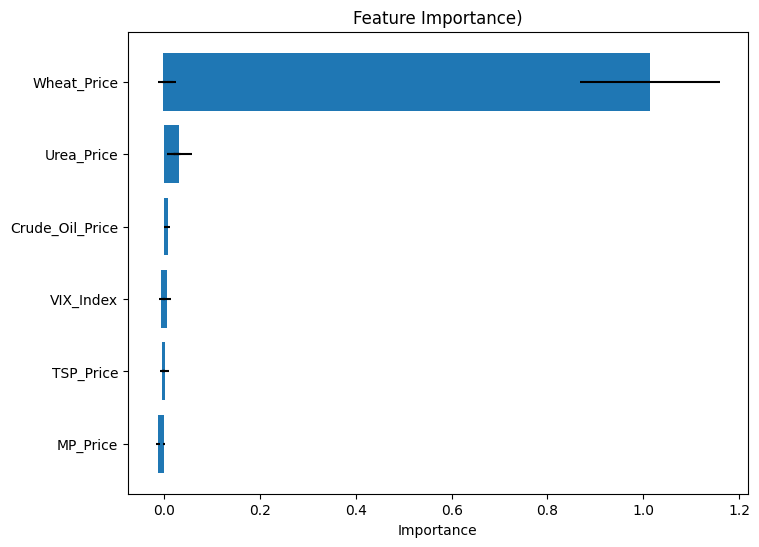

In [ ]:
from sklearn.inspection import permutation_importance
import matplotlib.pyplot as plt
import numpy as np

# Plot the sorted feature importances with original feature names
# Plotting the sorted feature importances
plt.figure(figsize=(8, 6))
plt.barh(sorted_feature_names, sorted_importances, xerr=sorted_importances_std)
plt.xlabel('Importance')
plt.title('Feature Importance)')
plt.gca().invert_yaxis()  # Invert the y-axis to have the most important feature at the top
plt.show()


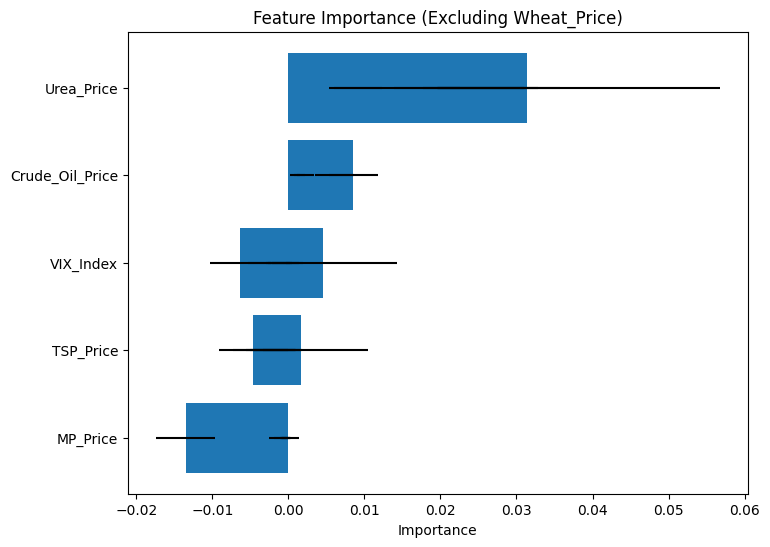

In [ ]:
# Remove 'Wheat_Price' from sorted features and importances
sorted_feature_names_no_wheat = [name for name in sorted_feature_names if name != 'Wheat_Price']
sorted_importances_no_wheat = [imp for name, imp in zip(sorted_feature_names, sorted_importances) if name != 'Wheat_Price']
sorted_importances_std_no_wheat = [std for name, std in zip(sorted_feature_names, sorted_importances_std) if name != 'Wheat_Price']

# Plot the sorted feature importances with original feature names (excluding 'Wheat_Price')
plt.figure(figsize=(8, 6))
plt.barh(sorted_feature_names_no_wheat, sorted_importances_no_wheat, xerr=sorted_importances_std_no_wheat)
plt.xlabel('Importance')
plt.title('Feature Importance (Excluding Wheat_Price)')
plt.gca().invert_yaxis()  # Invert the y-axis to have the most important feature at the top
plt.show()

## **Summary and Conclusions**

In this tutorial, we have explored the application of Long Short-Term Memory (LSTM) networks in price forecasting using the Keras-TensorFlow library. We have also delved into the importance of hyperparameter tuning and employed two powerful tools, Keras Tuner and Optuna, to optimize our model's performance.

#### Key Takeaways:

1. **Understanding LSTM Networks**:
   - LSTM networks are a type of Recurrent Neural Network (RNN) that are well-suited for time-series forecasting due to their ability to capture long-term dependencies in sequential data.
   - We constructed an LSTM model using Keras, highlighting the key components such as LSTM layers, Dropout layers, and Dense layers.

2. **Data Preparation**:
   - Proper data preprocessing is crucial for building effective models. This includes scaling the data, creating sequences, and splitting the data into training and validation sets.

3. **Model Building and Training**:
   - We defined and compiled the LSTM model, specifying loss functions, metrics, and optimizers.
   - To prevent overfitting, we used techniques such as Dropout layers and Early Stopping.

4. **Hyperparameter Tuning**:
   - Hyperparameter tuning is essential for enhancing model performance. We employed Keras Tuner and Optuna to systematically search for the best hyperparameters.
   - Keras Tuner provides a user-friendly interface for hyperparameter optimization, allowing us to define search spaces and explore different configurations.
   - Optuna offers advanced optimization techniques and pruning strategies to efficiently navigate the hyperparameter space and identify optimal settings.

5. **Evaluation and Results**:
   - After training the model, we evaluated its performance on validation data and used metrics such as Mean Squared Error (MSE) to assess accuracy.
   - The hyperparameter optimization process significantly improved our model's performance, demonstrating the value of tuning.


Price forecasting is a challenging task that benefits greatly from advanced neural network architectures like LSTM and rigorous hyperparameter optimization. By leveraging Keras and TensorFlow for model building and employing Keras Tuner and Optuna for hyperparameter tuning, we can achieve robust and accurate forecasting models.

We hope this tutorial has provided you with a comprehensive understanding of LSTM networks, the importance of data preprocessing, and the benefits of hyperparameter tuning. With these tools and techniques, you are well-equipped to tackle your own time-series forecasting projects and optimize your models for better performance.







## **Additional Resources**

Here are some important resources for learning more about LSTM with Keras-TensorFlow, hyperparameter tuning with Keras Tuner, and Optuna:

### LSTM with Keras-TensorFlow:
1. **Keras Documentation: LSTM Layers**:
   - [Keras LSTM Layer Documentation](https://keras.io/api/layers/recurrent_layers/lstm/)
   - Official documentation for the LSTM layer in Keras, including usage examples and parameters.

2. **TensorFlow Documentation: RNNs with Keras**:
   - [Recurrent Neural Networks (RNN) with Keras](https://www.tensorflow.org/guide/keras/rnn)
   - A comprehensive guide on building RNNs, including LSTMs, using Keras and TensorFlow.

3. **Blog Post: Time Series Forecasting with LSTMs in Keras**:
   - [Time Series Forecasting with LSTMs in Keras](https://machinelearningmastery.com/time-series-forecasting-long-short-term-memory-network-python/)
   - A detailed tutorial on how to use LSTMs for time series forecasting with Keras.

### Hyperparameter Tuning with Keras Tuner:
1. **Keras Tuner Documentation**:
   - [Keras Tuner Documentation](https://keras.io/keras_tuner/)
   - Official documentation for Keras Tuner, including installation, usage examples, and API reference.

2. **Guide: Hyperparameter Optimization with Keras Tuner**:
   - [Hyperparameter Optimization with Keras Tuner](https://www.tensorflow.org/tutorials/keras/keras_tuner)
   - A tutorial on using Keras Tuner for hyperparameter optimization in Keras models.

3. **Blog Post: Hyperparameter Tuning with Keras Tuner**:
   - [Hyperparameter Tuning with Keras Tuner](https://towardsdatascience.com/hyperparameter-tuning-with-keras-tuner-283474fb098)
   - A practical guide on how to use Keras Tuner for tuning hyperparameters in Keras models.

### Hyperparameter Tuning with Optuna:
1. **Optuna Documentation**:
   - [Optuna Official Documentation](https://optuna.readthedocs.io/en/stable/)
   - Comprehensive guide and API reference for using Optuna for hyperparameter optimization.

2. **Optuna Examples**:
   - [Optuna Examples Repository](https://github.com/optuna/optuna-examples)
   - A collection of example projects demonstrating how to use Optuna with various machine learning frameworks, including Keras.

3. **Blog Post: Hyperparameter Optimization with Optuna**:
   - [Hyperparameter Optimization with Optuna](https://towardsdatascience.com/hyperparameter-optimization-with-optuna-28b731e9b3a5)
   - An introduction to hyperparameter optimization using Optuna, with practical examples.

These resources should provide you with a solid foundation for working with LSTM models in Keras-TensorFlow, and for performing hyperparameter tuning using Keras Tuner and Optuna. If you have any specific questions or need further assistance, feel free to ask!